# Midterm Report 



## Background

Social media has become a new way of communication. It has revolutionized the relationship between users and digital products. The social media users are not only consumers, they are also content (comments) creators and spreaders. A massive amount of data has been generated directly by users and this allows us to measure people’s attention and attitude regarding a product in large scale. 

However, can the social media activities reflect our behaviors in real life?  Previous research showed that the tweets in a critical time period can successfully predict real world outcomes. A study on movie showed that both tweet - rate (number of tweets per hour) and sentiments could predict the box-office revenue (Asur, 2010) and the rating (Oghina,2012) of a particular movie. Also, the overall attitude of tweets has high correlations with people’s behavior in the stock market (Bollen,2011), political elections (Bermingham,2011), and etc.,

However, it may go beyond our expectations in the ways how these social media indicators are correlated with the real world outcomes. For example, products (De Vries,2012) and movies (e.g., [Tiny Times](https://en.wikipedia.org/wiki/Tiny_Times)) that have received negative comments were even more popular than those who received relatively higher ratings in social media. 
In this project, we are interested in how social media is related with users’ behavior in recreational activities. Also, we are curious about how the accuracy affected by factors such as the popularity of the social media and the diversity of information sources. 

Our hypothesis are:
- Both attention and attitude can predict the outcomes. Polarity will cause more attention 
- The popularity of social media and the diversity of information sources positively related with the accuracy.

In this project, we use movie as our subject area because:
- This subject area has research basis, which is both a good foundation of our project and a credible resource for comparing the project results.
- The real world outcomes (purchase behavior) can be easily measured by the box-office revenue.
- The “quality” of a product can be indicated by the IMDb score.




## Data-preparation & analysis

### 1. Movie Box Office Data  
   
   In the data preparation section, the first step of the project is to grasp movie data and twitter data separately:
For the movie data part, the main information we care about are movie’s name, total domestic box office amount (we narrow down the research area for only focus on North America region), movie’s release date, genre, and distributors. The first two features are the main identifier for the movie marked as our label. The third feature (release date) is used for targeting a specific time range for tweets search, and the rest of the features can be used for movie classification since we assume that correlations between twitter and a movie’s box office may also depends on movie’s type.

During the searching for box office data, we found that most of the movie box office information is either not complete or not freely available. There is no public free API available for large scale movie box office query. Therefore, we decide to write web scrapper by ourselves to collect box office data from [Boxoffice-Mojo](www.boxofficemojo.com). Boxoffice-Mojo is a website that tracks box office for more than 16,000 movies, basically, we use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) and python [urllib2](https://docs.python.org/2/library/urllib2.html) library  to do web data scrapping and saved the data into ‘movies_data.pkl’ file. 

In the following code, movie data is exported and sorted by its domestic total gross in decreasing order. The top 5 ranking movies are shown below:


In [1]:
import pickle
import numpy as np
import pandas as pd
import datetime
import unirest
import nltk
import sklearn
import string
import csv
from sklearn.decomposition import TruncatedSVD
from pattern.en import sentiment, parsetree
from glob import glob
from collections import Counter
from get_tweets import get_tweets
from text_classification import process_all, get_rare_words, create_features
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
plt.style.use("ggplot")


/Users/weijian/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
#load movie data from scrapper file
with open('movies_data.pkl', 'r') as picklefile:
    movies_scraped, movies_skipped = pickle.load(picklefile)

In [8]:
movies = pd.DataFrame(movies_scraped)
movies.dropna(axis=0, subset=['domestic_total_gross'], inplace=True)
movies.sort_values(by='domestic_total_gross', ascending=False, inplace=True)
movies.sort_values(by='release_date', ascending=False, inplace=True)
print len(movies)

14682


In [10]:
#get new movies after 20008
new_movies = movies.loc[movies['release_date'] >= np.datetime64('2008-01-01')]
print len(new_movies)
print 
print movies.dtypes

5642

BOM_id                          object
actors                          object
budget                         float64
director                        object
distributor                     object
domestic_total_gross           float64
genre                           object
movie_title                     object
opening_income_wend            float64
opening_theaters               float64
rating                          object
release_date            datetime64[ns]
runtime_mins                   float64
dtype: object


We can see that 14,682 movies’ information is dumped from the website and we checked our data by sorting their domestic total box office in descending order. We can see that the top 5 movies are:
* Star War VII        : 936,662,225 
* Avatar              : 749,766,139
* Jurassic Park IV    : 652,270,625
* Avengers II         : 623,357,910
* Titanic             : 600,788,188

It is already verified by other resource which means our data is reliable.
Here is the genre information for the collected movies and their counting distribution:

In [11]:
print new_movies['genre'].unique()
print new_movies['genre'].value_counts().head(10)

[u'Drama' u'Animation' u'Documentary' u'Thriller' u'Action / Adventure'
 u'Comedy' u'Action Drama' u'Crime Drama' u'Fantasy' u'Horror' u'Western'
 u'Drama / Thriller' u'Western Comedy' u'Romantic Comedy' u'Horror Comedy'
 u'Comedy / Drama' u'Action' u'Concert' u'Horror Thriller' u'Sports'
 u'Action / Crime' u'Crime Thriller' u'Romance' u'Sports Drama' u'Family'
 u'Adventure Comedy' u'Sci-Fi Thriller' u'Action Comedy' u'Historical Epic'
 u'War Drama' u'Romantic Thriller' u'Action Fantasy' u'Sci-Fi'
 u'Sci-Fi Adventure' u'Sci-Fi Action' u'Action Thriller' u'Adventure'
 u'Family Adventure' u'Comedy Thriller' u'Fantasy Comedy' u'Action Horror'
 u'Foreign' u'Musical' u'Music Drama' u'Historical Drama' u'Fantasy Drama'
 u'Unknown' u'Sci-Fi Comedy' u'Family Comedy' u'Sci-Fi Fantasy' u'Crime'
 u'Period Drama' u'Crime Comedy' u'Foreign / Action' u'Foreign / Horror'
 u'War' u'Sci-Fi Horror' u'IMAX' u'Period Action' u'Sports Comedy'
 u'Period Adventure' u'Period Comedy' u'War Romance' u'Romantic 

### 2. Twitter comments data
  
  When collecting twitter data, we also met some challenges. Our task is to collect tweets related to a specific film during the time period of the film release. By ‘related to a film’, we use keyword and hashtag search within one tweet. If one tweet contains a film’s name or hash-tag, we regard this tweet as related to this film. Unfortunately, Twitter [streaming API](https://dev.twitter.com/streaming/overview) only allows us to fetch the latest tweets within a week when given keywords and hashtag. Therefore, most of the films’ related tweets which posted earlier than a week cannot be fetched. We also tried several reliable open-sourced twitter data fetching library, since most of them are based on Twitter streaming API so they cannot satisfy our requirement. One of a not-very-popular library is found [here](https://github.com/Jefferson-Henrique/GetOldTweets-python). The basic idea is that when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider. After mimic we get the best advantage of Twitter Search on browsers, it can search the deepest oldest tweets. The good thing is that this library can fit most of our requirement, and the bad thing is that it is not a very reliable library due to its popularity, but so far we do not find any side effect or flaws when using this library.
 
Blocks below are codes we used to collect tweets data. Temporarily, we set the max tweets number for each movie to be 1,000. We will adjust this number in the future if the training/testing performance does not go well. Basic features we used for each tweet are its word count, retweet number, and whether it contains links. Besides, we conduct sentimental analysis from a [public API](http://text-processing.com/api/sentiment/). Due to the daily usage limitation for sentimental analysis API, we only choose seven films to do the sentimental analysis here, among the seven movies, four of them are popular movies which have very high box office,while the other threes are relatively normal movies:


In [39]:
time_range = datetime.timedelta(days=60)
maxtweets = 1000

def fetch_tweets(row):
    BOM_id = row['BOM_id']
    movie_title = row['movie_title']
    query = BOM_id + ' OR #' + BOM_id + ' OR ' + movie_title + ' OR #' + movie_title
    date = row['release_date']
    start = date.date().strftime('%Y-%m-%d')
    end = (date.date() + time_range).strftime('%Y-%m-%d')
    get_tweets(filename='data2/' + BOM_id, maxtweets=maxtweets, query=query, since=start, until=end)
    print movie_title, start, end

In [ ]:
for _, row in new_movies.iterrows():
    fetch_tweets(row)

In [12]:
#small samples for tweets sentiment feature
fetched_movie = {}
directories = glob('data/*')
print directories
for directory in directories:
    BOM_id = directory[5:]
    print BOM_id
    fetched_movie[BOM_id] = pd.read_csv(directory, sep=';', index_col=0)

['data/avatar', 'data/avengers11', 'data/jurassicpark4', 'data/misterlonely', 'data/starwars7', 'data/totalrecall2012rerelease', 'data/womenintrouble']
avatar
avengers11
jurassicpark4
misterlonely
starwars7
totalrecall2012rerelease
womenintrouble


In [19]:
def sentiment(text):
    # response = requests.post('http://text-processing.com/api/sentiment/', data={'text': text})
    response = unirest.post("https://japerk-text-processing.p.mashape.com/sentiment/",
        headers={
            "X-Mashape-Key": "EMrBfg9GO4mshgbevq2BtBZCdet3p1iXIWejsnKRDuWRNljYxI",
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/json"
          },
        params={
            "language": "english",
            "text": text
          }
    )
    if response.code != 200:
        print response.code
        print response.body
        print 'failed: {}'.format(text)
        return {'sentiment': None, 'probability': None}
    sentiment = response.body['label']
    if sentiment == 'pos':
        return {'sentiment': 1, 'probability': response.body['probability']}
    elif sentiment == 'neg':
        return {'sentiment': -1, 'probability': response.body['probability']}
    else:
        return {'sentiment': 0, 'probability': response.body['probability']}

In [20]:
def get_sentiments(movie_dict):
    for BOM_id, movie in movie_dict.items():
        sentiments = pd.DataFrame([sentiment(text) for text in movie['text']])
        movie_dict[BOM_id] = pd.concat([movie, sentiments], axis=1)
        #movie.to_csv('data/' + BOM_id, sep=';')
        print BOM_id

In [21]:
def ouput_csv(movie_dict):
    for BOM_id, movie in movie_dict.items():
        movie.to_csv('data/' + BOM_id, sep=';')

From the following result we can see that, according to the sample we collected, popular movies tend to have more positive reviews and more tweets and retweets amount as a whole. More detailed research and their correlation will be studied after midterm report.

In [13]:
for title, movie in fetched_movie.items():
    counter = Counter(movie['sentiment'])
    print title, " : ", counter, 'total: ', sum(counter.values())

starwars7  :  Counter({0.0: 650, 1.0: 335, -1.0: 11, nan: 1, nan: 1}) total:  998
avengers11  :  Counter({1: 777, 0: 183, -1: 39}) total:  999
womenintrouble  :  Counter({0: 370, 1: 192, -1: 113}) total:  675
misterlonely  :  Counter({0: 16, 1: 16, -1: 6}) total:  38
totalrecall2012rerelease  :  Counter({-1: 635, 1: 253, 0: 111}) total:  999
avatar  :  Counter({1: 467, 0: 287, -1: 246}) total:  1000
jurassicpark4  :  Counter({0: 481, 1: 334, -1: 185}) total:  1000


# Feature Extraction

Current Idea: Extract features from raw text but also try to reduce feature space.
1. Create parse tree and lemmatize each tweet.
2. Keep nouns, adjectives, and verbs.
3. Create word count, DF-IDF, sentiment, and length features
4. (If needed) use latent semantics analysis (i.e. Trucated SVD)
5. Add gaussian noise to response values

In [21]:
# with open('movies_clean_tweets_combined.pkl', 'r') as picklefile:
#     movies_clean_tweets_combined = pickle.load(picklefile)
#print movies_clean_tweets_combined
with open('movies_clean_features.pkl', 'r') as picklefile:
    clean_features = pickle.load(picklefile)
print clean_features

(TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'w...n', u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren', u'won', u'wouldn'],
        strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), <5278x475 sparse matrix of type '<type 'numpy.float64'>'
	with 1605674 stored elements in Compressed Sparse Row format>, CountVectorizer(analyzer=u'word

In [14]:
directories = glob('data2/*')

In [ ]:
movies_after_2008 = {}
for directory in directories:
    try:
        movies_after_2008[directory.rsplit('/',1)[1]] = pd.read_csv(directory, sep='","', engine='python', quoting=csv.QUOTE_ALL)
    except:
        print "something wrong with"+directory
with open('movies_after_2008_tweets.pkl', 'w') as picklefile:
    pickle.dump(movies_after_2008, picklefile, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
def clean(text):
    _text = text.lower()
    for char in string.punctuation:
        _text = _text.replace(char, " ")
    return _text

# create features for the 'text' column in df
def get_features(df):
#     trees = [parsetree(clean(text), lemmata=True)[0] for text in df['text']]
#     processed_tweets = df.assign(text=[
#         [word.lemma for word in tree if word.tag.startswith(('JJ', 'NN', 'VB', '!'))] # only keep verbs, noun, adjective
#         for tree in trees
#     ])
    processed_tweets = df
    rare_words = get_rare_words(processed_tweets) # get rare words
    lengths = [len(tweet) for tweet in processed_tweets['text']] # get length of words remaining
    sentiments = [sentiment(tweet)[0] for tweet in processed_tweets['text']] # get sentiment -1.0 ~ 1.0
    # create TfidfVectorizer, CountVectorizer and corresponding feature matrix
    tfidf, X_tfidf, count, X_count = create_features(processed_tweets, rare_words) 
    return tfidf, X_tfidf, count, X_count, lengths, sentiments

# combine multiple data frames into one by combining all texts in a data frame into one string
def combine_df(dfs):
    X = pd.DataFrame()
    text = []
    names = []
    for df_key in dfs:
        text.append(clean(' '.join(dfs[df_key]['text'])))
        names.append(df_key)
    X['name'] = names
    return X.assign(text=text)

def get_topn_words(processed_tweets,n):
    counter = Counter()
    for _, row in processed_tweets.iterrows():
        counter.update(row['text'])
    return counter

In [ ]:
combined_df = combine_df(movies_after_2008)
combined_df.to_pickle("movies_tweets_combined.pkl")
tknzr = TweetTokenizer()
counter = Counter()
tmp = []
for _,row in combined_df.iterrows():
    tmp.append([ word for word in tknzr.tokenize(row['text']) if word not in stopwords.words('english')])
combined_df['text'] = tmp
with open('movies_clean_tweets_combined.pkl', 'w') as picklefile:
    pickle.dump(combined_df, picklefile)


In [ ]:
topn_words =  get_topn_words(movies_clean_tweets_combined,500)
clean_features = get_features(movies_clean_tweets_combined)
with open('movies_clean_features.pkl', 'w') as picklefile:
    pickle.dump(clean_features, picklefile)


# ------------do not delete below--------------------

In [42]:
# Latent Semantic Analysis (Trucated SVD) reduce dimension of feature matrix
svd_tfidf = TruncatedSVD(n_components=100, n_iter=15, random_state=42)
svd_count = TruncatedSVD(n_components=100, n_iter=15, random_state=42)
svd_tfidf.fit(clean_features[1])
svd_count.fit(clean_features[3])

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=15,
       random_state=42, tol=0.0)

In [43]:
# percentage of variance explained
print(svd_tfidf.explained_variance_ratio_.sum()) 
print(svd_count.explained_variance_ratio_.sum())

0.0533529862208
0.170975991361


# ------------do not delete above--------------------

In [22]:
tfidf = clean_features[1].todense()
count = clean_features[3].todense()
with open('movies_features.pkl', 'r') as picklefile:
    ori_features = pickle.load(picklefile)
length = ori_features[4]
sentiments = ori_features[5]
maxlength = max(length)*1.0
normal_length = [item/maxlength for item in length]
feature_matrix = np.append(tfidf, np.array(normal_length).reshape(5278,1), 1)
feature_matrix = np.append(feature_matrix, np.array(sentiments).reshape(5278,1), 1)
print feature_matrix.shape

(5278, 477)


NameError: name 'ori_features' is not defined

# Prediction
1. Linear Regression
2. Logistic Regression

In [23]:
with open('movies_after_2008_tweets.pkl', 'r') as picklefile:
    movies_after_2008 = pickle.load(picklefile)

In [27]:
box_office =[]
for name in movies_clean_tweets_combined['name']:
    box_office.append(new_movies.loc[new_movies['BOM_id'] == name]['domestic_total_gross'].iloc[0])
box_office = np.array(box_office)
print len(box_office)
print box_office[:10]


5278
[  5.14900000e+03   5.50526700e+06   5.94780000e+04   6.19796800e+07
   4.97000000e+03   1.07352000e+05   1.23960000e+04   4.94940000e+04
   2.86639000e+05   2.79558000e+05]


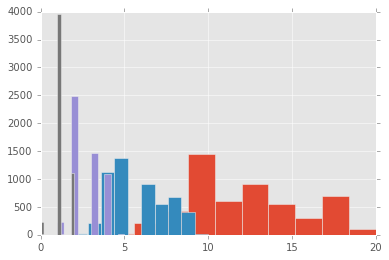

[  8.  15.  10. ...,  10.  17.   9.]


In [45]:
%matplotlib inline
box_office_log = np.trunc(np.log(box_office))
box_office_log_2 = np.trunc(np.log(box_office)/2)
box_office_log_4 = np.trunc(np.log(box_office)/4)
box_office_log_8 = np.trunc(np.log(box_office)/8)

plt.hist(box_office_log)
plt.hist(box_office_log_2)
plt.hist(box_office_log_4)
plt.hist(box_office_log_8)

plt.show()
print box_office_log

In [47]:
print max(box_office_log)
print max(box_office_log_2)
print max(box_office_log_4)
print max(box_office_log_8)

20.0
10.0
5.0
2.0


In [48]:
from sklearn import linear_model
import time
def linear(X, y, X_te):
    """ Given labelsf and VGG features, predict the breed of the testing set. 
    Args: 
        X (numpy ndarray) : 2D array of VGG features, each row is a set of features for a single example
        y (numpy ndarray) : 1D array of labels corresponding to the features in X
        X_te (numpy ndarray) : 2D array of VGG features for unlabeled examples
    Returns: 
        (numpy ndarray) 1D array of predicted labels for the unlabeled examples in X_te
    """
    model = linear_model.LinearRegression()
    model.fit(X,y)
    return model.predict(X_te)
def logestic(X, y, X_te):
    """ Given labelsf and VGG features, predict the breed of the testing set. 
    Args: 
        X (numpy ndarray) : 2D array of VGG features, each row is a set of features for a single example
        y (numpy ndarray) : 1D array of labels corresponding to the features in X
        X_te (numpy ndarray) : 2D array of VGG features for unlabeled examples
    Returns: 
        (numpy ndarray) 1D array of predicted labels for the unlabeled examples in X_te
    """
    model = linear_model.LogisticRegression(C=1)
    model.fit(X,y)
    return model.predict(X_te)


start = time.time()
y_p = linear(feature_matrix[:5000], box_office[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING LINEAR REGRESSION: {} in {} seconds".format(np.mean(np.abs(y_p-box_office[-200:])/y_p), end-start)

start = time.time()
y_p = logestic(feature_matrix[:5000], box_office_log[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING LOGESTIC REGRESSION 20 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log[-200:]), end-start)

start = time.time()
y_p = logestic(feature_matrix[:5000], box_office_log_2[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING LOGESTIC REGRESSION 10 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_2[-200:]), end-start)

start = time.time()
y_p = logestic(feature_matrix[:5000], box_office_log_4[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING LOGESTIC REGRESSION 5 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_4[-200:]), end-start)

start = time.time()
y_p = logestic(feature_matrix[:5000], box_office_log_8[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING LOGESTIC REGRESSION 2 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_8[-200:]), end-start)


Validation accuracy USING LINEAR REGRESSION: 0.533285171396 in 0.324118852615 seconds
Validation accuracy USING LOGESTIC REGRESSION 20 GROUP: 0.19 in 4.61636209488 seconds
Validation accuracy USING LOGESTIC REGRESSION 10 GROUP: 0.345 in 2.87497591972 seconds
Validation accuracy USING LOGESTIC REGRESSION 5 GROUP: 0.625 in 1.43918585777 seconds
Validation accuracy USING LOGESTIC REGRESSION 2 GROUP: 0.835 in 0.859684944153 seconds


## References
Asur, Sitaram, and Bernardo A. Huberman. "Predicting the future with social media." Web Intelligence and Intelligent Agent Technology (WI-IAT), 2010 IEEE/WIC/ACM International Conference on. Vol. 1. IEEE, 2010.

Bermingham, Adam, and Alan F. Smeaton. "On using Twitter to monitor political sentiment and predict election results." (2011).

Bollen, Johan, Huina Mao, and Xiaojun Zeng. "Twitter mood predicts the stock market." Journal of Computational Science 2.1 (2011): 1-8.

De Vries, Lisette, Sonja Gensler, and Peter SH Leeflang. "Popularity of brand posts on brand fan pages: An investigation of the effects of social media marketing." Journal of Interactive Marketing 26.2 (2012): 83-91.

Oghina, Andrei, et al. "Predicting imdb movie ratings using social media." European Conference on Information Retrieval. Springer Berlin Heidelberg, 2012.